<a id="top"></a>

<div class="alert alert-block alert-success">
<b>Kernel Author:</b>  <br>
<a href="https://bhishanpdl.github.io/" , target="_blank">Bhishan Poudel, Ph.D Astrophysics</a> .
</div>

<a id="data-desc"></a>

<h1> Modelling Customer Churn using Logistic Regression and Hyperband</h1>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

References
- [github: xgboost](https://github.com/dmlc/xgboost)
- [kaggle: Predicting Customer Churn](https://www.kaggle.com/raywilliam/customer-churn-prediction-xgboost-hyperbandcv)

<a id="lib"></a>

<h1> Load the libraries </h1>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [1]:
import time

time_start_notebook = time.time()

## Colab

In [2]:
%%capture
import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    # usual imports
    !pip install watermark
    !pip install scikit-plot

    # HPO
    !git clone https://github.com/thuijskens/scikit-hyperband.git
    sys.path.append('scikit-hyperband/hyperband')

    # update modules
    !pip uninstall xgboost
    !pip install -U xgboost

    print('Environment: Google Colab')

In [3]:
from search import HyperbandSearchCV

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import os,sys,time
import matplotlib.pyplot as plt
sns.set()
import joblib
from tqdm import tqdm_notebook as tqdm

from sklearn.preprocessing import OneHotEncoder
import imblearn
from imblearn.over_sampling import SMOTE
import sklearn.metrics as skmetrics

# warnings
import warnings
from sklearn.exceptions import ConvergenceWarning
from scipy.optimize.linesearch import LineSearchWarning

warnings.simplefilter('ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)
warnings.simplefilter('ignore', category=LineSearchWarning)

SEED = 100
pd.set_option('max_columns',100)
pd.set_option('max_colwidth',200)
pd.set_option('plotting.backend','matplotlib') # matplotlib, bokeh, altair, plotly

%load_ext watermark
%watermark -iv

joblib   0.17.0
autopep8 1.5.2
json     2.0.9
imblearn 0.7.0
pandas   1.1.0
seaborn  0.11.0
numpy    1.18.4



<a id="useful" ></a>

<h1> Useful Scripts </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [5]:
def show_methods(obj, ncols=4,contains=None):
    lst = [i for i in dir(obj) if i[0]!='_' ]
    if contains is not None:
        lst = [i for i in lst if contains in i]
    df = pd.DataFrame(np.array_split(lst,ncols)).T.fillna('')
    return df

<a id="load-data" ></a>

<h1> Load the Data </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [6]:
path_data_train = '../data/raw/train.csv'
path_data_test = '../data/raw/test.csv'

if ENV_COLAB:
    path_data_train = 'https://raw.githubusercontent.com/bhishanpdl/Datasets/master/Projects/Telco_Customer_Churn/raw/train.csv'
    path_data_test = 'https://raw.githubusercontent.com/bhishanpdl/Datasets/master/Projects/Telco_Customer_Churn/raw/test.csv.csv'

In [7]:
df_train = pd.read_csv(path_data_train)
df_test = pd.read_csv(path_data_test)

print(df_train.shape)
print(df_test.shape)
df_train.head(2).append(df_train.tail(2))

(5634, 21)
(1409, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1621-YNCJH,Female,0,Yes,No,36,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,No,Yes,Two year,Yes,Credit card (automatic),106.05,3834.4,No
1,7143-BQIBA,Male,0,No,No,10,Yes,No,DSL,Yes,No,No,Yes,Yes,No,Month-to-month,No,Bank transfer (automatic),62.25,612.95,No
5632,0862-PRCBS,Female,0,Yes,Yes,68,Yes,Yes,Fiber optic,No,Yes,No,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),103.75,7039.45,No
5633,4656-CAURT,Male,0,No,No,69,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),23.95,1713.1,No


In [8]:
target_name = 'Churn'

<a id="eda" ></a>

<h1> Data Processing  </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [9]:
def clean_data(dfx):
    dfx = dfx.copy()

    # from eda we see that gender has no effect
    cols_drop = ['customerID','gender']
    dfx = dfx.drop(cols_drop,axis=1)

    # replace values
    dic_replace = [
        {'SeniorCitizen': {0:'No', 1:'Yes'}},
        {'MultipleLines': {'No phone service':'N/A'}},
        {'SeniorCitizen': {'No':'Not_SenCit', 'Yes':'SeniorCitizen'}},
        {'Partner': {'No':'No_Partner', 'Yes':'Partner'}},
        {'Dependents': {'No':'No_Dependents', 'Yes':'Dependents'}},
        {'PaperlessBilling': {'No':'No_PaperlessBill', 'Yes':'PaperlessBill'}},
        {'PhoneService': {'No':'No_PhoneService', 'Yes':'PhoneService'}},
        {'MultipleLines': {'No':'No_MultiLines', 'Yes':'MultiLines', 'N/A': 'No_PhoneService'}},
        {'InternetService': {'No':'No_internet_service'}},
        {'OnlineSecurity': {'No':'No_OnlineSecurity', 'Yes':'OnlineSecurity'}},
        {'OnlineBackup': {'No':'No_OnlineBackup', 'Yes':'OnlineBackup'}},
        {'DeviceProtection': {'No':'No_DeviceProtection', 'Yes':'DeviceProtection'}},
        {'TechSupport': {'No':'No_TechSupport', 'Yes':'TechSupport'}},
        {'StreamingTV': {'No':'No_StreamingTV', 'Yes':'StreamingTV'}},
        {'StreamingMovies': {'No':'No_StreamingMov', 'Yes':'StreamingMov'}}
    ]
    for dic in dic_replace:
        dfx = dfx.replace(dic)

    # impute 
    dfx['TotalCharges'] = pd.to_numeric(dfx['TotalCharges'],errors='coerce').fillna(0)

    # sum of features
    dfx['SenCit_Dependents']  = dfx['SeniorCitizen'] + '_' + dfx['Dependents']
    dfx['Partner_Dependents'] = dfx['Partner']       + '_' + dfx['Dependents']
    dfx['SenCit_Partner']     = dfx['SeniorCitizen'] + '_' + dfx['Partner']
    dfx['SenCit_Contract']    = dfx['SeniorCitizen'] + '_' + dfx['Contract']
    dfx['SenCit_TechSupport'] = dfx['SeniorCitizen'] + '_' + dfx['TechSupport']
    dfx['SenCit_PayMeth']     = dfx['SeniorCitizen'] + '_' + dfx['PaymentMethod']

    # aggration features
    temp = (dfx.groupby('Contract')['TotalCharges'].agg(['mean'])
             .rename({'mean':'Contract_mean_totCharges'},axis=1))
    dfx = pd.merge(dfx, temp, on='Contract', how='left')

    dfx['Contract_totCharges_diff'] = (dfx['TotalCharges'] 
                                      - dfx['Contract_mean_totCharges'])

    temp = (dfx.groupby('PaymentMethod')['MonthlyCharges'].agg(['mean'])
             .rename({'mean':'PayMeth_mean_monthCharges'},axis=1))
    dfx = pd.merge(dfx, temp, on='PaymentMethod', how='left')

    dfx['PayMeth_monthCharges_diff'] = (dfx['MonthlyCharges'] 
                                       - dfx['PayMeth_mean_monthCharges'])

    multiLines_dict = {'No_PhoneService':0, 'No_MultiLines':1, 'MultiLines':2}
    dfx['MultipleLines_Ordinal'] = dfx['MultipleLines'].map(multiLines_dict)

    # Ordinal encoding of 'InternetService'
    intServ_dict = {'No_internet_service':0, 'DSL':1, 'Fiber_optic':2}
    dfx['InternetService_Ordinal'] = dfx['InternetService'].map(intServ_dict)

    # Ordinal encoding of 'Contract'
    contract_dict = {'Month-to-month':0, 'One_year':1, 'Two_year':2}
    dfx['Contract_Ordinal'] = dfx['Contract'].map(contract_dict)

    # Drop unnecessary columns that have been encoded
    ordinal_drop_cols = ['MultipleLines', 'InternetService', 'Contract']
    dfx.drop(ordinal_drop_cols, axis=1, inplace=True)

    # Apply one-hot encoder to the relevant columns
    cols_ohe = ['SeniorCitizen', 'Partner', 'Dependents', 
               'PaperlessBilling', 'PhoneService', 'OnlineSecurity', 
               'OnlineBackup', 'DeviceProtection', 'TechSupport',
               'StreamingTV', 'StreamingMovies', 'PaymentMethod',
               'SenCit_Dependents', 'Partner_Dependents', 'SenCit_Partner',
               'SenCit_Contract', 'SenCit_TechSupport', 'SenCit_PayMeth']

    enc_ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
    df_ohe = pd.DataFrame(enc_ohe.fit_transform(dfx[cols_ohe]))

    # Replace default column names with more descriptive ones
    df_ohe.columns = enc_ohe.get_feature_names(cols_ohe)

    # One-hot encoding removed index; put it back
    df_ohe.index = dfx.index

    # Remove categorical columns (will replace with one-hot encoding)
    dfx.drop(cols_ohe, axis=1, inplace=True)

    # Add one-hot encoded columns to numerical features
    dfx = pd.concat([dfx, df_ohe], axis=1)
    
    # remove nans
    cols_drop = ['InternetService_Ordinal','Contract_Ordinal']
    dfx = dfx.drop(cols_drop, axis=1)
    
    # remove white spaces from column names
    dfx = dfx.rename(columns=lambda x: x.strip())
    
    return dfx

In [10]:
df_train = clean_data(df_train)
df_test  = clean_data(df_test)

In [11]:
df_Xtrain  = df_train.drop(target_name,axis=1)
ser_ytrain = df_train[target_name].map({'No':0, 'Yes':1})

df_Xtest   = df_test.drop(target_name,axis=1)
ser_ytest  = df_test[target_name].map({'No':0, 'Yes':1})

In [12]:
df_Xtrain.sum().sum(), ser_ytrain.sum().sum()

(26621171.299999997, 1495)

In [13]:
df_Xtrain.head(2)

,tenure,MonthlyCharges,TotalCharges,Contract_mean_totCharges,Contract_totCharges_diff,PayMeth_mean_monthCharges,PayMeth_monthCharges_diff,MultipleLines_Ordinal,SeniorCitizen_Not_SenCit,SeniorCitizen_SeniorCitizen,Partner_No_Partner,Partner_Partner,Dependents_Dependents,Dependents_No_Dependents,PaperlessBilling_No_PaperlessBill,PaperlessBilling_PaperlessBill,PhoneService_No_PhoneService,PhoneService_PhoneService,OnlineSecurity_No internet service,OnlineSecurity_No_OnlineSecurity,OnlineSecurity_OnlineSecurity,OnlineBackup_No internet service,OnlineBackup_No_OnlineBackup,OnlineBackup_OnlineBackup,DeviceProtection_DeviceProtection,DeviceProtection_No internet service,DeviceProtection_No_DeviceProtection,TechSupport_No internet service,TechSupport_No_TechSupport,TechSupport_TechSupport,StreamingTV_No internet service,StreamingTV_No_StreamingTV,StreamingTV_StreamingTV,StreamingMovies_No internet service,StreamingMovies_No_StreamingMov,StreamingMovies_StreamingMov,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SenCit_Dependents_Not_SenCit_Dependents,SenCit_Dependents_Not_SenCit_No_Dependents,SenCit_Dependents_SeniorCitizen_Dependents,SenCit_Dependents_SeniorCitizen_No_Dependents,Partner_Dependents_No_Partner_Dependents,Partner_Dependents_No_Partner_No_Dependents,Partner_Dependents_Partner_Dependents,Partner_Dependents_Partner_No_Dependents,SenCit_Partner_Not_SenCit_No_Partner,SenCit_Partner_Not_SenCit_Partner,SenCit_Partner_SeniorCitizen_No_Partner,SenCit_Partner_SeniorCitizen_Partner,SenCit_Contract_Not_SenCit_Month-to-month,SenCit_Contract_Not_SenCit_One year,SenCit_Contract_Not_SenCit_Two year,SenCit_Contract_SeniorCitizen_Month-to-month,SenCit_Contract_SeniorCitizen_One year,SenCit_Contract_SeniorCitizen_Two year,SenCit_TechSupport_Not_SenCit_No internet service,SenCit_TechSupport_Not_SenCit_No_TechSupport,SenCit_TechSupport_Not_SenCit_TechSupport,SenCit_TechSupport_SeniorCitizen_No internet service,SenCit_TechSupport_SeniorCitizen_No_TechSupport,SenCit_TechSupport_SeniorCitizen_TechSupport,SenCit_PayMeth_Not_SenCit_Bank transfer (automatic),SenCit_PayMeth_Not_SenCit_Credit card (automatic),SenCit_PayMeth_Not_SenCit_Electronic check,SenCit_PayMeth_Not_SenCit_Mailed check,SenCit_PayMeth_SeniorCitizen_Bank transfer (automatic),SenCit_PayMeth_SeniorCitizen_Credit card (automatic),SenCit_PayMeth_SeniorCitizen_Electronic check,SenCit_PayMeth_SeniorCitizen_Mailed check
0,36,106.05,3834.40,3683.643192,150.756808,65.801934,40.248066,2,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10,62.25,612.95,1370.923131,-757.973131,67.564819,-5.314819,1,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
ser_ytrain.head(2)

0    0
1    0
Name: Churn, dtype: int64

# Oversampling: SMOTE

In [15]:
from imblearn.over_sampling import SMOTE # smote needs sklearn 0.23.1
import sklearn
sklearn.__version__

'0.23.1'

In [16]:
smote = SMOTE(sampling_strategy=0.5, random_state=SEED)

df_Xtrain_smote, ser_ytrain_smote = smote.fit_resample(df_Xtrain,ser_ytrain)

In [17]:
# smote = SMOTE(ratio='minority', random_state=SEED)
# df_Xtrain_smote, ser_ytrain_smote = smote.fit_sample(df_Xtrain, ser_ytrain)

# Scaling Numerical Features

In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

In [19]:
df_Xtrain.head()

,tenure,MonthlyCharges,TotalCharges,Contract_mean_totCharges,Contract_totCharges_diff,PayMeth_mean_monthCharges,PayMeth_monthCharges_diff,MultipleLines_Ordinal,SeniorCitizen_Not_SenCit,SeniorCitizen_SeniorCitizen,Partner_No_Partner,Partner_Partner,Dependents_Dependents,Dependents_No_Dependents,PaperlessBilling_No_PaperlessBill,PaperlessBilling_PaperlessBill,PhoneService_No_PhoneService,PhoneService_PhoneService,OnlineSecurity_No internet service,OnlineSecurity_No_OnlineSecurity,OnlineSecurity_OnlineSecurity,OnlineBackup_No internet service,OnlineBackup_No_OnlineBackup,OnlineBackup_OnlineBackup,DeviceProtection_DeviceProtection,DeviceProtection_No internet service,DeviceProtection_No_DeviceProtection,TechSupport_No internet service,TechSupport_No_TechSupport,TechSupport_TechSupport,StreamingTV_No internet service,StreamingTV_No_StreamingTV,StreamingTV_StreamingTV,StreamingMovies_No internet service,StreamingMovies_No_StreamingMov,StreamingMovies_StreamingMov,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SenCit_Dependents_Not_SenCit_Dependents,SenCit_Dependents_Not_SenCit_No_Dependents,SenCit_Dependents_SeniorCitizen_Dependents,SenCit_Dependents_SeniorCitizen_No_Dependents,Partner_Dependents_No_Partner_Dependents,Partner_Dependents_No_Partner_No_Dependents,Partner_Dependents_Partner_Dependents,Partner_Dependents_Partner_No_Dependents,SenCit_Partner_Not_SenCit_No_Partner,SenCit_Partner_Not_SenCit_Partner,SenCit_Partner_SeniorCitizen_No_Partner,SenCit_Partner_SeniorCitizen_Partner,SenCit_Contract_Not_SenCit_Month-to-month,SenCit_Contract_Not_SenCit_One year,SenCit_Contract_Not_SenCit_Two year,SenCit_Contract_SeniorCitizen_Month-to-month,SenCit_Contract_SeniorCitizen_One year,SenCit_Contract_SeniorCitizen_Two year,SenCit_TechSupport_Not_SenCit_No internet service,SenCit_TechSupport_Not_SenCit_No_TechSupport,SenCit_TechSupport_Not_SenCit_TechSupport,SenCit_TechSupport_SeniorCitizen_No internet service,SenCit_TechSupport_SeniorCitizen_No_TechSupport,SenCit_TechSupport_SeniorCitizen_TechSupport,SenCit_PayMeth_Not_SenCit_Bank transfer (automatic),SenCit_PayMeth_Not_SenCit_Credit card (automatic),SenCit_PayMeth_Not_SenCit_Electronic check,SenCit_PayMeth_Not_SenCit_Mailed check,SenCit_PayMeth_SeniorCitizen_Bank transfer (automatic),SenCit_PayMeth_SeniorCitizen_Credit card (automatic),SenCit_PayMeth_SeniorCitizen_Electronic check,SenCit_PayMeth_SeniorCitizen_Mailed check
0,36,106.05,3834.40,3683.643192,150.756808,65.801934,40.248066,2,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10,62.25,612.95,1370.923131,-757.973131,67.564819,-5.314819,1,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,25,19.15,477.60,1370.923131,-893.323131,43.792328,-24.642328,1,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,7,20.00,137.60,1370.923131,-1233.323131,67.564819,-47.564819,1,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,24,20.30,459.95,1370.923131,-910.973131,43.792328,-23.492328,1,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,

In [20]:
df_Xtrain.columns[df_Xtrain.apply(pd.Series.nunique)>5]

Index(['tenure', 'MonthlyCharges', 'TotalCharges', 'Contract_totCharges_diff',
       'PayMeth_monthCharges_diff'],
      dtype='object')

In [21]:
# Define the columns we wish to transform
cols_scale = ['tenure', 'MonthlyCharges', 'TotalCharges',
              'Contract_totCharges_diff',
              'PayMeth_monthCharges_diff']

# Scale the relevant columns
transformer = ColumnTransformer([('scaler', StandardScaler(), cols_scale)], 
                                remainder='passthrough')
transformer.fit(df_Xtrain)

df_Xtrain_scaled = pd.DataFrame(transformer.transform(df_Xtrain))
df_Xtest_scaled = pd.DataFrame(transformer.transform(df_Xtest))

#features
df_Xtrain_scaled.columns = df_Xtrain.columns
df_Xtest_scaled.columns = df_Xtest.columns

In [22]:
df_Xtrain_scaled.head()

,tenure,MonthlyCharges,TotalCharges,Contract_mean_totCharges,Contract_totCharges_diff,PayMeth_mean_monthCharges,PayMeth_monthCharges_diff,MultipleLines_Ordinal,SeniorCitizen_Not_SenCit,SeniorCitizen_SeniorCitizen,Partner_No_Partner,Partner_Partner,Dependents_Dependents,Dependents_No_Dependents,PaperlessBilling_No_PaperlessBill,PaperlessBilling_PaperlessBill,PhoneService_No_PhoneService,PhoneService_PhoneService,OnlineSecurity_No internet service,OnlineSecurity_No_OnlineSecurity,OnlineSecurity_OnlineSecurity,OnlineBackup_No internet service,OnlineBackup_No_OnlineBackup,OnlineBackup_OnlineBackup,DeviceProtection_DeviceProtection,DeviceProtection_No internet service,DeviceProtection_No_DeviceProtection,TechSupport_No internet service,TechSupport_No_TechSupport,TechSupport_TechSupport,StreamingTV_No internet service,StreamingTV_No_StreamingTV,StreamingTV_StreamingTV,StreamingMovies_No internet service,StreamingMovies_No_StreamingMov,StreamingMovies_StreamingMov,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SenCit_Dependents_Not_SenCit_Dependents,SenCit_Dependents_Not_SenCit_No_Dependents,SenCit_Dependents_SeniorCitizen_Dependents,SenCit_Dependents_SeniorCitizen_No_Dependents,Partner_Dependents_No_Partner_Dependents,Partner_Dependents_No_Partner_No_Dependents,Partner_Dependents_Partner_Dependents,Partner_Dependents_Partner_No_Dependents,SenCit_Partner_Not_SenCit_No_Partner,SenCit_Partner_Not_SenCit_Partner,SenCit_Partner_SeniorCitizen_No_Partner,SenCit_Partner_SeniorCitizen_Partner,SenCit_Contract_Not_SenCit_Month-to-month,SenCit_Contract_Not_SenCit_One year,SenCit_Contract_Not_SenCit_Two year,SenCit_Contract_SeniorCitizen_Month-to-month,SenCit_Contract_SeniorCitizen_One year,SenCit_Contract_SeniorCitizen_Two year,SenCit_TechSupport_Not_SenCit_No internet service,SenCit_TechSupport_Not_SenCit_No_TechSupport,SenCit_TechSupport_Not_SenCit_TechSupport,SenCit_TechSupport_SeniorCitizen_No internet service,SenCit_TechSupport_SeniorCitizen_No_TechSupport,SenCit_TechSupport_SeniorCitizen_TechSupport,SenCit_PayMeth_Not_SenCit_Bank transfer (automatic),SenCit_PayMeth_Not_SenCit_Credit card (automatic),SenCit_PayMeth_Not_SenCit_Electronic check,SenCit_PayMeth_Not_SenCit_Mailed check,SenCit_PayMeth_SeniorCitizen_Bank transfer (automatic),SenCit_PayMeth_SeniorCitizen_Credit card (automatic),SenCit_PayMeth_SeniorCitizen_Electronic check,SenCit_PayMeth_SeniorCitizen_Mailed check
0,0.150197,1.378513,0.692345,0.074950,1.463193,3683.643192,65.801934,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.909449,-0.077392,-0.735308,-0.376832,-0.193217,1370.923131,67.564819,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.298115,-1.510030,-0.795291,-0.444122,-0.895857,1370.923131,43.792328,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-1.031715,-1.481776,-0.945970,-0.613155,-1.729189,1370.923131,67.564819,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.338870,-1.471804,-0.803113,-0.452897,-0.854049,1370.923131,43.792328,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0

In [23]:
df_Xtrain_scaled.sum().sum(), df_Xtest_scaled.sum().sum()

(13273998.150000809, 3374475.968378649)

In [24]:
df_Xtrain_scaled.isna().sum().sum(), df_Xtest_scaled.isna().sum().sum()

(0, 0)

In [25]:
# Scale the relevant columns
transformer = ColumnTransformer([('scaler', StandardScaler(), cols_scale)], 
                                remainder='passthrough')
transformer.fit(df_Xtrain_smote)

df_Xtrain_smote_scaled = pd.DataFrame(transformer.transform(df_Xtrain_smote))
df_Xtest_scaled = pd.DataFrame(transformer.transform(df_Xtest)) # Xtest is NEVER oversampled.

#features
df_Xtrain_smote_scaled.columns = df_Xtrain.columns
df_Xtest_scaled.columns = df_Xtest.columns

<a id="" ></a>

<h1>  Modelling </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [26]:
from sklearn.linear_model import LogisticRegression

In [27]:
model = LogisticRegression()
model.fit(df_Xtrain_smote_scaled, ser_ytrain_smote)
ypreds = model.predict(df_Xtest)
skmetrics.confusion_matrix(np.array(ser_ytest), ypreds)

array([[801, 234],
       [289,  85]])

# Hyperband SearchCV

In [ ]:
# help(HyperbandSearchCV)

In [34]:
X = df_Xtrain_smote_scaled
y = ser_ytrain_smote

In [35]:
X = df_Xtrain_scaled
y = ser_ytrain

<Figure size 576x360 with 0 Axes>

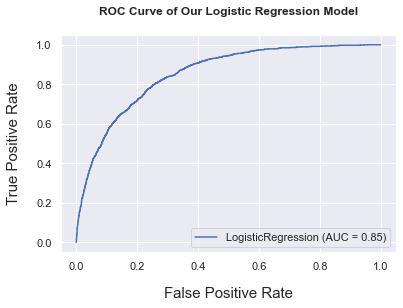

Best parameters:   {'C': 1.4960484007536512, 'max_iter': 333, 'penalty': 'l2', 'solver': 'newton-cg'}
AUC - ROC score:   0.8464761745782802
CPU times: user 3min 13s, sys: 3.94 s, total: 3min 17s
Wall time: 1min 19s


In [36]:
%%time

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_randfloat 
from sklearn import metrics
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
import warnings
from sklearn.exceptions import ConvergenceWarning
from scipy.optimize.linesearch import LineSearchWarning

warnings.simplefilter('ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)
warnings.simplefilter('ignore', category=LineSearchWarning)

# Define our model
fixed_params = {'dual': False, 
                'random_state': SEED,
                'n_jobs': 1
               }
params_hyp = {'max_iter': sp_randint(200,500),
              'solver': ['lbfgs', 'sag', 'newton-cg'],
              'penalty': ['l2'],
              'C': sp_randfloat(0.01, 10),
             }
lr = LogisticRegression(**fixed_params)


# Perform Hyperparameter Tuning
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=SEED)
search_lr = HyperbandSearchCV(lr,params_hyp, 
                              resource_param = 'max_iter',
                              min_iter       = 200,
                              max_iter       = 1000,
                              cv             = cv, 
                              scoring        = 'roc_auc',
                              refit          = True,
                              verbose        = 0,
                              random_state   = SEED
                          )
search_lr.fit(X, y)

# Print ROC Curve
plt.figure(figsize=(8,5))
metrics.plot_roc_curve(search_lr.best_estimator_, X, y)
plt.title('ROC Curve of Our Logistic Regression Model', pad=20, fontweight='bold')
plt.xlabel('False Positive Rate', labelpad=15, fontsize=15)
plt.ylabel('True Positive Rate', labelpad=15, fontsize=15)
plt.show()

# Print results of hyperparameter tuning
print('Best parameters:  ', search_lr.best_params_)
print('AUC - ROC score:  ', search_lr.best_score_)

In [37]:
model = LogisticRegression(**search_lr.best_params_)
model.fit(df_Xtrain_smote_scaled, ser_ytrain_smote)
ypreds = model.predict(df_Xtest)
skmetrics.confusion_matrix(np.array(ser_ytest), ypreds)

array([[ 82, 953],
       [ 39, 335]])

<a id="" ></a>

<h1>  Model Evaluation </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [38]:
import sklearn.metrics as skmetrics

ytest = np.array(ser_ytest)
report = f"""
Accuracy  : {skmetrics.accuracy_score(ytest,ypreds):.4f}
Precision : {skmetrics.precision_score(ytest,ypreds):.4f}
Recall    : {skmetrics.recall_score(ytest,ypreds):.4f}
F1-score  : {skmetrics.f1_score(ytest,ypreds):.4f}
AUC       : {skmetrics.roc_auc_score(ytest,ypreds):.4f}
"""
print(report)

print(skmetrics.classification_report(ytest,ypreds))
# look at the value of recall for 1. It must be nearer to 1.

print(skmetrics.confusion_matrix(ytest,ypreds))


Accuracy  : 0.2960
Precision : 0.2601
Recall    : 0.8957
F1-score  : 0.4031
AUC       : 0.4875

              precision    recall  f1-score   support

           0       0.68      0.08      0.14      1035
           1       0.26      0.90      0.40       374

    accuracy                           0.30      1409
   macro avg       0.47      0.49      0.27      1409
weighted avg       0.57      0.30      0.21      1409

[[ 82 953]
 [ 39 335]]


<a id="" ></a>

<h1>  Time Taken </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [39]:
time_taken = time.time() - time_start_notebook
h,m = divmod(time_taken,60*60)
print('Time taken to run whole notebook: {:.0f} hr '\
      '{:.0f} min {:.0f} secs'.format(h, *divmod(m,60)))

Time taken to run whole notebook: 0 hr 4 min 49 secs
